Teste de SOM usando <a href="https://en.wikipedia.org/wiki/Democracy_Index">Democracy Index data</a> - Wikipedia.

In [312]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import util
from pathlib import Path
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from class_manipulates_path import ManipulatePath
from class_preprocessing_refactor import Preprocessing
from class_format_data import FormatData

from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
util.init()

'Módulo util importado com sucesso.'

In [313]:
manipulate_path = ManipulatePath()

preprocessing = Preprocessing()

format_data = FormatData()

path_raw_data = manipulate_path.get_path_raw_data()

In [314]:
df_preprocessing = pd.read_parquet(manipulate_path.get_path_preprocessing_real_data_all_classes())

In [315]:
contagem_classes = df_preprocessing['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_preprocessing) * 100
porcentagem_classes

class
0.0    32.679781
5.0    30.983203
7.0    29.009351
1.0     4.797527
6.0     1.810310
2.0     0.719828
Name: count, dtype: float64

In [316]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [317]:
def split_dataframe(df, target_column=None, test_size=0.0003, random_state=42):
    if target_column:
        # Se a coluna alvo for fornecida, realizar a divisão estratificada
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        for train_index, test_index in split.split(df, df[target_column]):
            df_1 = df.iloc[train_index]
            df_2 = df.iloc[test_index]
    else:
        # Se a coluna alvo não for fornecida, realizar a divisão simples
        df_1, df_2 = train_test_split(df, test_size=test_size, random_state=random_state)

    return df_1, df_2

In [318]:
df_1, df_2 = split_dataframe(df_preprocessing, target_column='class')

In [319]:
df_2.shape

(294, 5)

In [320]:
df_2.index

DatetimeIndex(['2014-03-18 08:48:25', '2014-03-19 12:43:55',
               '2014-01-24 12:45:17', '2014-03-14 22:53:27',
               '2018-06-18 20:03:04', '2014-03-17 19:38:06',
               '2014-03-25 18:27:45', '2018-06-18 21:44:45',
               '2017-02-27 00:50:42', '2014-03-20 01:24:41',
               ...
               '2017-08-01 20:33:44', '2018-06-18 16:28:08',
               '2014-01-24 19:50:48', '2014-03-19 16:59:08',
               '2014-03-15 03:46:41', '2017-08-01 14:40:00',
               '2014-03-15 03:57:32', '2017-08-01 15:52:46',
               '2014-01-25 01:12:27', '2017-02-26 22:01:07'],
              dtype='datetime64[ns]', name='timestamp', length=294, freq=None)

In [321]:
contagem_classes = df_2['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_2) * 100
porcentagem_classes

class
0.0    32.653061
5.0    30.952381
7.0    28.911565
1.0     4.761905
6.0     2.040816
2.0     0.680272
Name: count, dtype: float64

In [322]:
df_2

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
timestamp,,,,,
2014-03-18 08:48:25,7583908.0,98.40878,3261349.0,43.81690,5.0
2014-03-19 12:43:55,6337455.0,101.37720,2604916.0,50.60535,0.0
2014-01-24 12:45:17,18437220.0,116.87180,9401221.0,74.79038,0.0
2014-03-14 22:53:27,14355880.0,86.46021,7123661.0,32.15251,5.0
2018-06-18 20:03:04,20647810.0,118.22820,10566870.0,70.51610,7.0
...,...,...,...,...,...
2017-08-01 14:40:00,18234740.0,118.90300,2512656.0,79.66547,1.0
2014-03-15 03:57:32,13765210.0,86.31015,6423888.0,31.33380,5.0
2017-08-01 15:52:46,18174060.0,118.98110,2507937.0,80.05676,1.0


Selecionando os atributos para o SOM

In [323]:
model_input = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']

X = df_2[model_input].values

In [324]:
X # cada linha é um timestamp

array([[7.583908e+06, 9.840878e+01, 3.261349e+06, 4.381690e+01],
       [6.337455e+06, 1.013772e+02, 2.604916e+06, 5.060535e+01],
       [1.843722e+07, 1.168718e+02, 9.401221e+06, 7.479038e+01],
       ...,
       [1.817406e+07, 1.189811e+02, 2.507937e+06, 8.005676e+01],
       [1.745588e+07, 1.176501e+02, 7.950811e+06, 7.915257e+01],
       [1.333767e+07, 1.181305e+02, 5.347480e+06, 7.377396e+01]])

E normalizando os dados!

In [325]:
X = StandardScaler().fit_transform(X)

In [326]:
X

array([[-1.31194903, -0.45657048, -0.80611975, -0.91978396],
       [-1.54480895, -0.28878287, -0.98553601, -0.53819078],
       [ 0.7156456 ,  0.58703729,  0.87203008,  0.82130106],
       ...,
       [ 0.66648256,  0.70626382, -1.01204231,  1.11733546],
       [ 0.53231357,  0.63103008,  0.47560401,  1.06650902],
       [-0.23704241,  0.65818432, -0.23593842,  0.76416594]])

Treinando o SOM

In [327]:
lr_ordering = 2 #Taxa de aprendizado - Ordering phase
lr_finetuning = 0.2 #Taxa de aprendizado - Finetuning phase

# vizinhança
sigma_ordering = 2
sigma_finetuning = 0.4

topology = "rectangular"

ordering_time = 1000
finetuning_time = 3000

In [328]:
# Lista de tamanhos do SOM a serem testados
som_sizes = [8, 10, 12, 14, 16, 18, 20]

# Lista de valores de K a serem testados
k_values = [4, 5, 6, 7, 8]

# Variáveis para armazenar os melhores resultados
best_size = None
best_k = None
best_silhouette_score = -1

# Loop para testar diferentes tamanhos do SOM
for size in som_sizes:
    print(f"#### Tamanho {size} ####")
    # Treinamento do SOM
    som = MiniSom(size, size, len(X[0]), learning_rate=lr_ordering,
                  neighborhood_function='gaussian', sigma=sigma_ordering,
                  random_seed=1, topology=topology)
    
    som.pca_weights_init(X)
    som.train_random(X, 1000, verbose=False)
    
    som._learning_rate = lr_finetuning  # Para mudar a taxa de aprendizado durante o período de finetuning
    som._sigma = sigma_finetuning  # Para mudar a vizinhança durante o período de finetuning
    som.train_random(X, finetuning_time, verbose=False)
    
    # Obtendo os vencedores
    winners = np.array([som.winner(x) for x in X])
    winners_reshaped = np.apply_along_axis(lambda x: np.array([x[0], x[1]]), 1, winners)
    
    # Loop para treinar o K-means e calcular a pontuação de silhueta para cada valor de K
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(winners_reshaped)
        labels = kmeans.labels_
        #silhouette_avg = silhouette_score(winners_reshaped, labels)
        df_2["class_prev"] = labels
        silhouette_avg = silhouette_score(df_2.drop(columns=["class", "class_prev"]).values, df_2["class_prev"].values)
        
        #print(f'Para size={size} e K={k}, a pontuação de silhueta é {silhouette_avg}')
        
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_size = size
            best_k = k

print(f'O melhor tamanho do SOM é {best_size} e o melhor valor de K é {best_k} com uma pontuação de silhueta de {best_silhouette_score}')

#### Tamanho 8 ####


c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marce\AppData\Local\Temp\ipykernel_29188\3041024410.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = labels
c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Use

#### Tamanho 10 ####


c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marce\AppData\Local\Temp\ipykernel_29188\3041024410.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = labels
c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Use

#### Tamanho 12 ####


c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marce\AppData\Local\Temp\ipykernel_29188\3041024410.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = labels
c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Use

#### Tamanho 14 ####


c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Periodo\2_Data_Science\2_Trabalho_Final\3_3W\4_modeling\mapa_kohonen\minisom.py:563: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)
c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marce\AppData\Local\Temp\ipykernel_29188\3041024410.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = labels
c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-pac

#### Tamanho 16 ####


c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marce\AppData\Local\Temp\ipykernel_29188\3041024410.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = labels
c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Use

#### Tamanho 18 ####


c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marce\AppData\Local\Temp\ipykernel_29188\3041024410.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = labels
c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Use

#### Tamanho 20 ####


c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Periodo\2_Data_Science\2_Trabalho_Final\3_3W\4_modeling\mapa_kohonen\minisom.py:563: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


O melhor tamanho do SOM é 10 e o melhor valor de K é 4 com uma pontuação de silhueta de 0.44846727051923263


c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marce\AppData\Local\Temp\ipykernel_29188\3041024410.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = labels
c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Use

In [500]:
size = 10
som = MiniSom(size, size, len(X[0]), learning_rate = lr_ordering,
              neighborhood_function='gaussian', sigma=sigma_ordering,
              random_seed=1, topology=topology)

som.pca_weights_init(X)
som.train_random(X, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.08013010048999912


In [501]:
som = MiniSom(size, size, len(X[0]), learning_rate = lr_ordering,
              neighborhood_function='gaussian', sigma=sigma_ordering,
              random_seed=1, topology=topology)

som.pca_weights_init(X)
som.train_random(X, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.08013010048999912


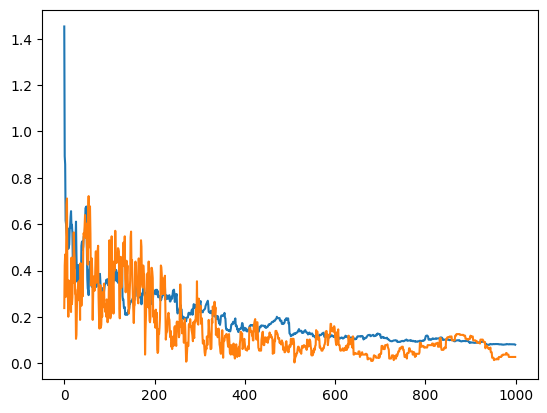

In [502]:
plt.plot(som._quantization_error)
plt.plot(som._topographic_error)

In [503]:
som._learning_rate = lr_finetuning #Para mudar a taxa de aprendizado durante o período de finetuning
som._sigma = sigma_finetuning # Para mudar a vizinhança durante o período de finetuning
som.train_random(X, finetuning_time, verbose=True)

 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 0.04117182971171531


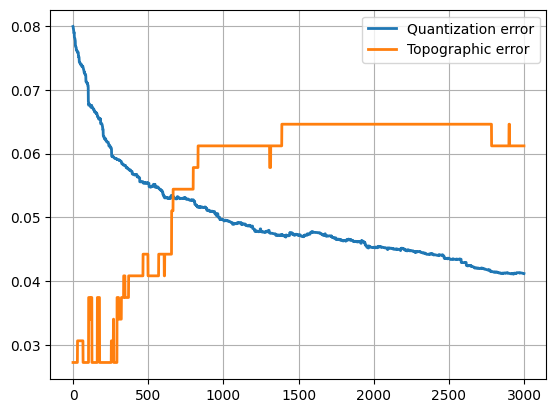

In [504]:
plt.plot(som._quantization_error,linewidth=2,label='Quantization error')
plt.plot(som._topographic_error,linewidth=2, label='Topographic error')
plt.legend()
plt.grid()

Mapa social dos países
----

Com o mapa já treinado, veremos de que forma o mapa está organizado. Para isso, vamos criar um mapa anotando os países correspondentes ao neurônio vencedor. Vamos usar, para isso, as variáveis criadas no início do script.

In [505]:
df_2["LABEL"] = ['R' + str(i+1) for i in range(len(df_2))]

C:\Users\marce\AppData\Local\Temp\ipykernel_29188\728563986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["LABEL"] = ['R' + str(i+1) for i in range(len(df_2))]


In [506]:
df_2["LABEL"]

timestamp
2014-03-18 08:48:25      R1
2014-03-19 12:43:55      R2
2014-01-24 12:45:17      R3
2014-03-14 22:53:27      R4
2018-06-18 20:03:04      R5
                       ... 
2017-08-01 14:40:00    R290
2014-03-15 03:57:32    R291
2017-08-01 15:52:46    R292
2014-01-25 01:12:27    R293
2017-02-26 22:01:07    R294
Name: LABEL, Length: 294, dtype: object

In [507]:
# 0.0    32.679612
# 5.0    30.983344
# 7.0    29.009394
# 1.0     4.797312
# 6.0     1.810306
# 2.0 

In [508]:
category_color = {0: 'darkgreen',
                  1: 'limegreen',
                  2: 'darkorange',
                  5: 'crimson',
                  6: 'dodgerblue',
                  7: 'purple'}
colors_dict = {c: category_color[dm] for c, dm in zip(df_2["LABEL"],
                                                      df_2["class"])}

In [509]:
def shorten_country(c):
    if len(c) > 6:
        return c[:6]
    else:
        return c

country_map = som.labels_map(X, df_2["LABEL"])

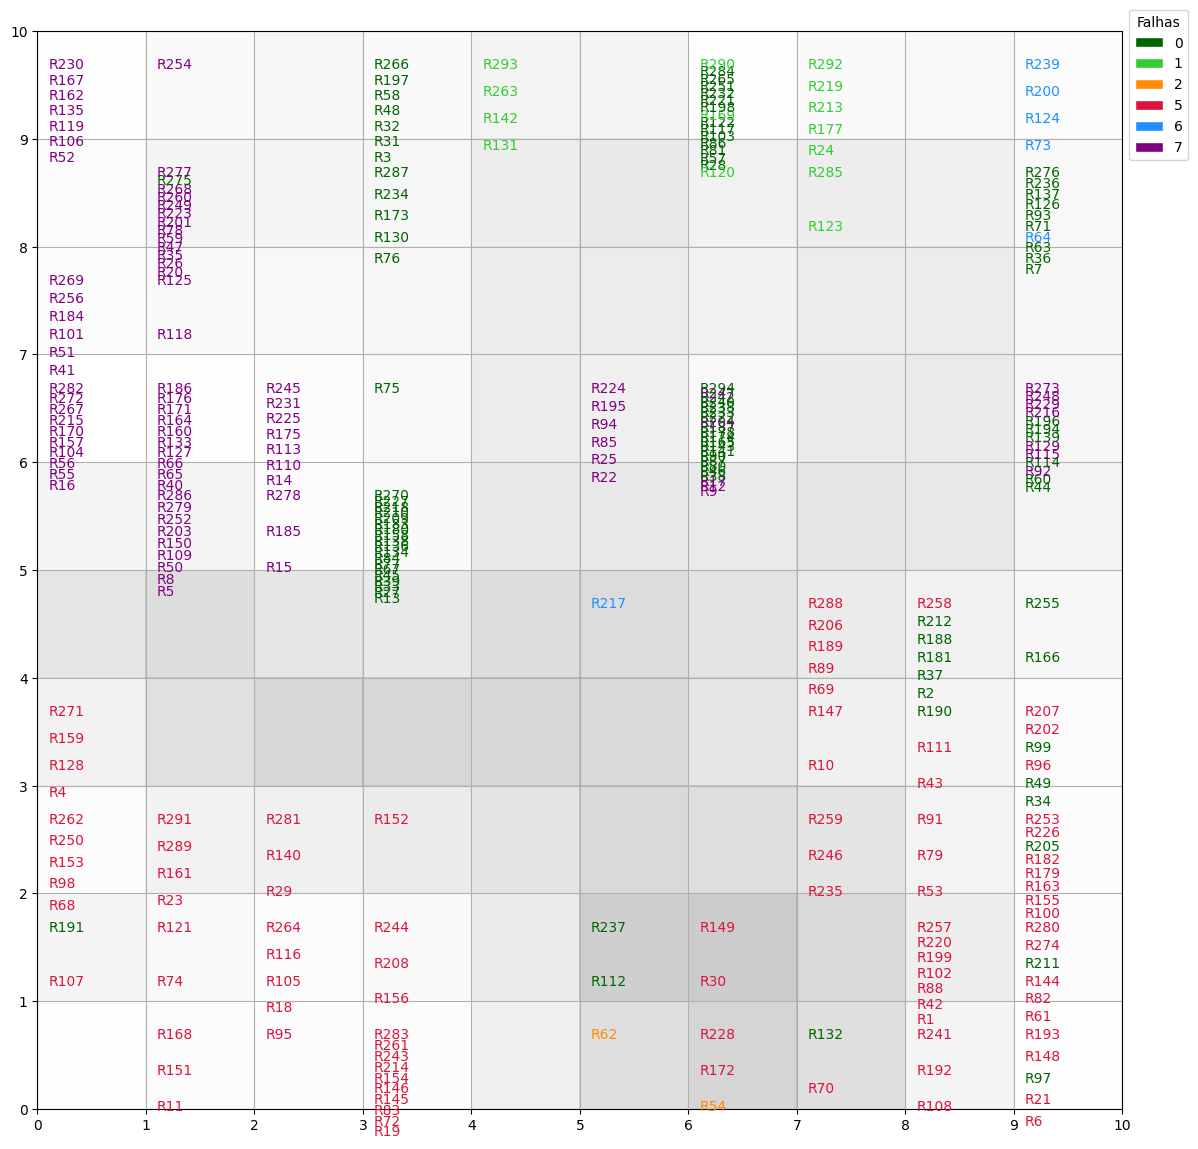

In [510]:
som.plot_winning(country_map,alias_label=shorten_country,colorize=colors_dict,label_color=category_color)

Mapa das variáveis
----

Vamos fazer o mapa para cada uma das características. Iremos ver a magnitude dos pessos associados a cada neurônio.

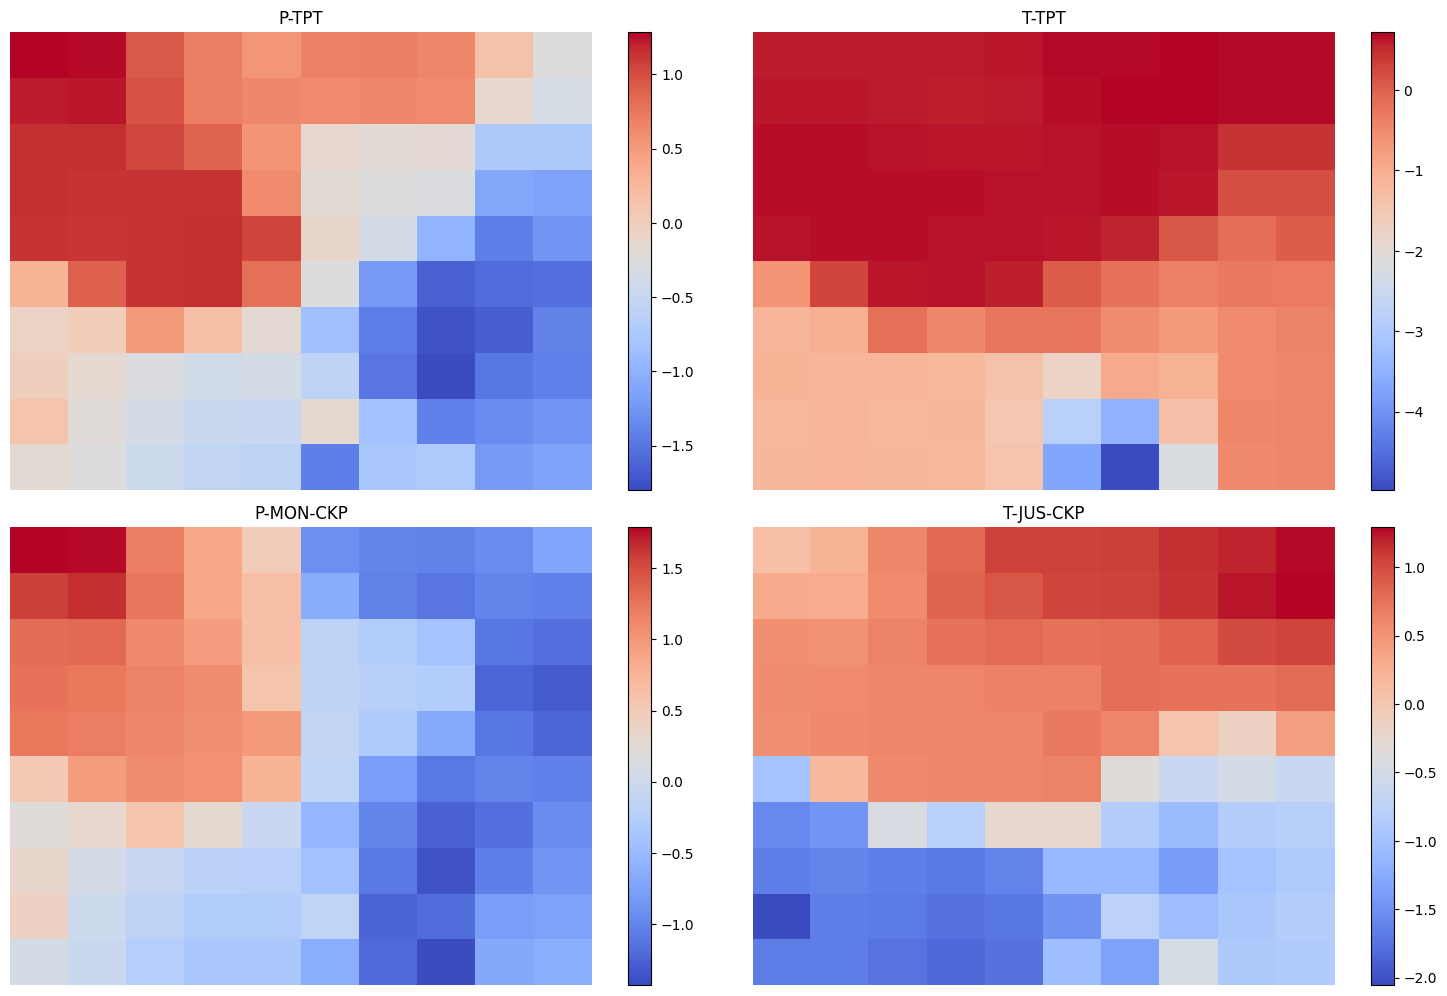

In [511]:
som.plot_map(nrows=3,ncols=2,feature_names=model_input)

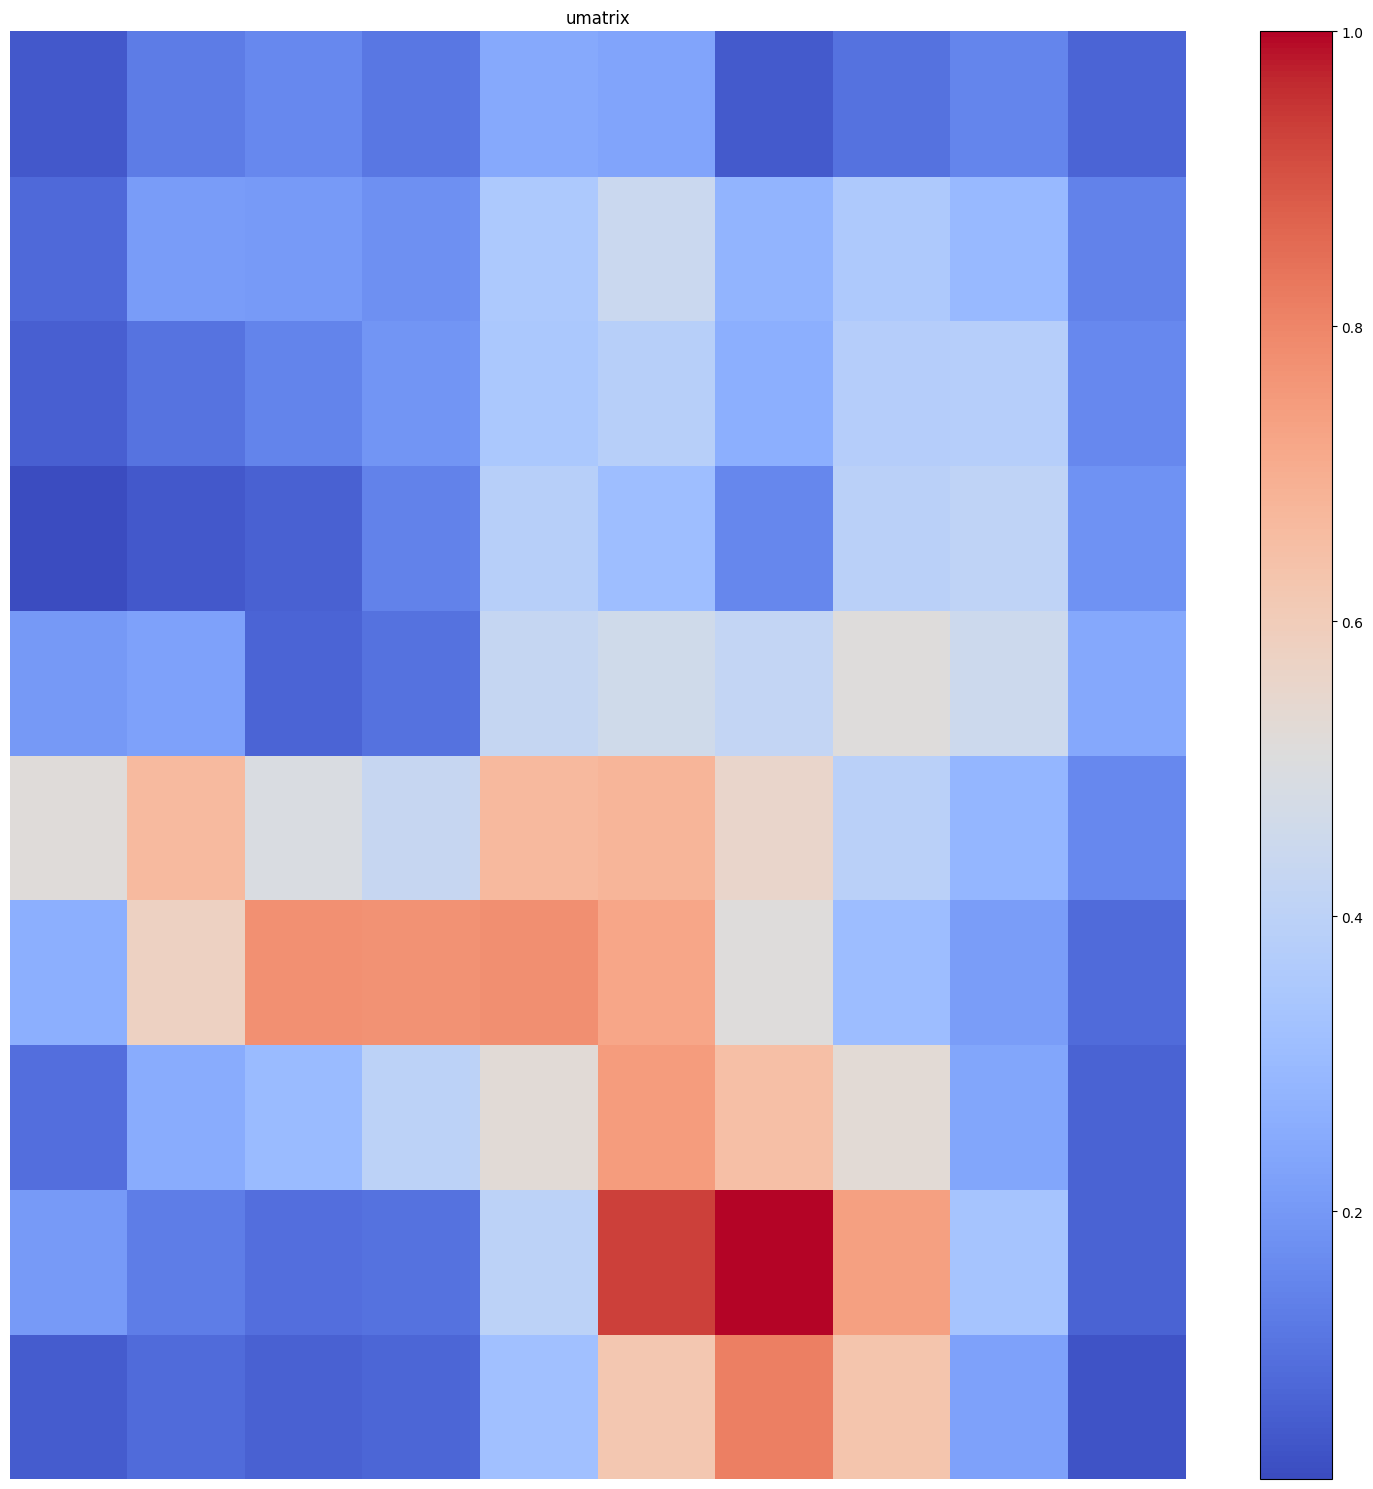

In [512]:
som.plot_umatrix()

# Rotulando

In [513]:
winners = np.array([som.winner(x) for x in X])

In [514]:
winners

array([[8, 1],
       [8, 4],
       [3, 9],
       [0, 3],
       [1, 5],
       [9, 0],
       [9, 8],
       [1, 5],
       [6, 6],
       [7, 3],
       [1, 0],
       [6, 6],
       [3, 5],
       [2, 6],
       [2, 5],
       [0, 6],
       [6, 6],
       [2, 1],
       [3, 0],
       [1, 8],
       [9, 0],
       [5, 6],
       [1, 2],
       [7, 9],
       [5, 6],
       [1, 8],
       [3, 5],
       [6, 9],
       [2, 2],
       [6, 1],
       [3, 9],
       [3, 9],
       [3, 5],
       [9, 3],
       [1, 8],
       [9, 8],
       [8, 4],
       [6, 6],
       [3, 5],
       [1, 6],
       [0, 7],
       [8, 1],
       [8, 3],
       [9, 6],
       [3, 5],
       [6, 6],
       [1, 8],
       [3, 9],
       [9, 3],
       [1, 5],
       [0, 7],
       [0, 9],
       [8, 2],
       [6, 0],
       [0, 6],
       [0, 6],
       [6, 9],
       [3, 9],
       [1, 8],
       [9, 6],
       [9, 1],
       [5, 0],
       [9, 8],
       [9, 8],
       [1, 6],
       [1, 6],
       [3,

In [515]:
winners_reshaped = np.apply_along_axis(lambda x: np.array([x[0], x[1]]), 1, winners)

In [516]:
winners_reshaped

array([[8, 1],
       [8, 4],
       [3, 9],
       [0, 3],
       [1, 5],
       [9, 0],
       [9, 8],
       [1, 5],
       [6, 6],
       [7, 3],
       [1, 0],
       [6, 6],
       [3, 5],
       [2, 6],
       [2, 5],
       [0, 6],
       [6, 6],
       [2, 1],
       [3, 0],
       [1, 8],
       [9, 0],
       [5, 6],
       [1, 2],
       [7, 9],
       [5, 6],
       [1, 8],
       [3, 5],
       [6, 9],
       [2, 2],
       [6, 1],
       [3, 9],
       [3, 9],
       [3, 5],
       [9, 3],
       [1, 8],
       [9, 8],
       [8, 4],
       [6, 6],
       [3, 5],
       [1, 6],
       [0, 7],
       [8, 1],
       [8, 3],
       [9, 6],
       [3, 5],
       [6, 6],
       [1, 8],
       [3, 9],
       [9, 3],
       [1, 5],
       [0, 7],
       [0, 9],
       [8, 2],
       [6, 0],
       [0, 6],
       [0, 6],
       [6, 9],
       [3, 9],
       [1, 8],
       [9, 6],
       [9, 1],
       [5, 0],
       [9, 8],
       [9, 8],
       [1, 6],
       [1, 6],
       [3,

In [517]:
# Suponha que winners_reshaped seja o seu conjunto de dados
# winners_reshaped = ...

# Lista de valores de K a serem testados
k_values = [4, 5, 6, 7, 8]

# Variáveis para armazenar o melhor K e a melhor pontuação de silhueta
best_k = None
best_silhouette_score = -1

# Loop para treinar o K-means e calcular a pontuação de silhueta para cada valor de K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(winners_reshaped)
    labels = kmeans.labels_

    df_2["class_prev"] = labels
    silhouette_avg = silhouette_score(df_2.drop(columns=["class", "LABEL", "class_prev"]).values, df_2["class_prev"].values)
    #silhouette_avg = silhouette_score(winners_reshaped, labels)
    
    print(f'Para K={k}, a pontuação de silhueta é {silhouette_avg}')
    
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_k = k

print(f'O melhor valor de K é {best_k} com uma pontuação de silhueta de {best_silhouette_score}')

Para K=4, a pontuação de silhueta é 0.4484672705188602
Para K=5, a pontuação de silhueta é 0.31293868086868026
Para K=6, a pontuação de silhueta é 0.3222559899474843
Para K=7, a pontuação de silhueta é 0.3134950623423539
Para K=8, a pontuação de silhueta é 0.34567048924131655
O melhor valor de K é 4 com uma pontuação de silhueta de 0.4484672705188602


c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marce\AppData\Local\Temp\ipykernel_29188\4066344915.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = labels
c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Use

In [518]:
from sklearn.cluster import KMeans

In [519]:
best_k

4

In [520]:
kmeans = KMeans(n_clusters=best_k, random_state=42).fit(winners_reshaped)

c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [521]:
cluster_labels = kmeans.labels_

In [522]:
cluster_labels

array([1, 1, 0, 3, 0, 1, 2, 0, 2, 1, 3, 2, 0, 0, 0, 0, 2, 3, 3, 0, 1, 2,
       3, 2, 2, 0, 0, 2, 3, 1, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 0, 1, 1, 2,
       0, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 1, 1, 2, 2, 0, 0,
       0, 3, 1, 1, 2, 3, 2, 3, 0, 0, 0, 0, 1, 2, 2, 1, 3, 0, 2, 2, 2, 1,
       1, 2, 1, 2, 2, 2, 3, 1, 1, 3, 1, 1, 0, 1, 2, 0, 3, 0, 3, 1, 0, 0,
       1, 1, 0, 2, 2, 3, 2, 0, 0, 2, 3, 2, 2, 2, 0, 2, 0, 3, 2, 0, 0, 1,
       0, 0, 0, 0, 2, 0, 2, 3, 2, 0, 2, 1, 3, 3, 1, 1, 1, 0, 3, 3, 3, 3,
       1, 3, 0, 0, 3, 0, 3, 0, 1, 0, 2, 1, 0, 3, 2, 0, 0, 1, 0, 2, 0, 0,
       2, 2, 1, 0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 3, 1, 1, 2, 2, 2, 0, 2,
       1, 2, 0, 1, 0, 2, 1, 1, 1, 3, 0, 0, 1, 1, 2, 3, 0, 2, 1, 0, 2, 1,
       2, 2, 0, 2, 0, 1, 0, 1, 2, 0, 0, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2,
       3, 3, 0, 1, 2, 2, 0, 3, 2, 0, 1, 0, 1, 0, 1, 1, 1, 0, 3, 3, 0, 3,
       2, 0, 0, 0, 0, 0, 3, 0, 2, 1, 0, 2, 0, 0, 0, 1, 3, 0, 3, 2, 2, 0,
       0, 1, 3, 2, 3, 2, 0, 2])

In [523]:
len(cluster_labels)

294

In [524]:
df_2["class_prev"] = cluster_labels

C:\Users\marce\AppData\Local\Temp\ipykernel_29188\2933655561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = cluster_labels


In [525]:
df_2["class"]

timestamp
2014-03-18 08:48:25    5.0
2014-03-19 12:43:55    0.0
2014-01-24 12:45:17    0.0
2014-03-14 22:53:27    5.0
2018-06-18 20:03:04    7.0
                      ... 
2017-08-01 14:40:00    1.0
2014-03-15 03:57:32    5.0
2017-08-01 15:52:46    1.0
2014-01-25 01:12:27    1.0
2017-02-26 22:01:07    0.0
Name: class, Length: 294, dtype: float64

In [526]:
df_2["class_prev"]

timestamp
2014-03-18 08:48:25    1
2014-03-19 12:43:55    1
2014-01-24 12:45:17    0
2014-03-14 22:53:27    3
2018-06-18 20:03:04    0
                      ..
2017-08-01 14:40:00    2
2014-03-15 03:57:32    3
2017-08-01 15:52:46    2
2014-01-25 01:12:27    0
2017-02-26 22:01:07    2
Name: class_prev, Length: 294, dtype: int32

In [527]:
df_2["class_prev"].unique()

array([1, 0, 3, 2])

In [528]:
len(winners_reshaped)

294

In [529]:
def plot_two_variables(df, var1, var2, binary_column=None):
    """
    Plota um gráfico de dispersão para duas variáveis de um DataFrame, colorindo os pontos conforme uma coluna binária, se fornecida.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - var1: Nome da primeira variável (eixo x).
        - var2: Nome da segunda variável (eixo y).
        - binary_column: Nome da coluna binária usada para colorir os pontos (opcional).
    """
    plt.figure(figsize=(10, 6))

    if binary_column is not None:
        # Obtendo os valores únicos da coluna binária
        classes = df[binary_column].unique()

        # Criando um mapeamento de classe para cor
        colors = {cls: plt.cm.tab10(i) for i, cls in enumerate(classes)}

        # Colorindo os pontos de acordo com as classes
        for cls in classes:
            df_cls = df[df[binary_column] == cls]
            plt.scatter(df_cls[var1], df_cls[var2], color=colors[cls], label=cls, alpha=0.5)
        
        plt.legend(title=binary_column)
    else:
        plt.scatter(df[var1], df[var2], alpha=0.5)

    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'Gráfico de Dispersão: {var1} vs {var2}')
    plt.grid(True)
    plt.show()

In [530]:
df_2

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,class_prev,LABEL,class_prev_mapped
timestamp,,,,,,,,
2014-03-18 08:48:25,7583908.0,98.40878,3261349.0,43.81690,5.0,1,R1,7.0
2014-03-19 12:43:55,6337455.0,101.37720,2604916.0,50.60535,0.0,1,R2,7.0
2014-01-24 12:45:17,18437220.0,116.87180,9401221.0,74.79038,0.0,0,R3,6.0
2014-03-14 22:53:27,14355880.0,86.46021,7123661.0,32.15251,5.0,3,R4,2.0
2018-06-18 20:03:04,20647810.0,118.22820,10566870.0,70.51610,7.0,0,R5,6.0
...,...,...,...,...,...,...,...,...
2017-08-01 14:40:00,18234740.0,118.90300,2512656.0,79.66547,1.0,2,R290,2.0
2014-03-15 03:57:32,13765210.0,86.31015,6423888.0,31.33380,5.0,3,R291,2.0
2017-08-01 15:52:46,18174060.0,118.98110,2507937.0,80.05676,1.0,2,R292,2.0


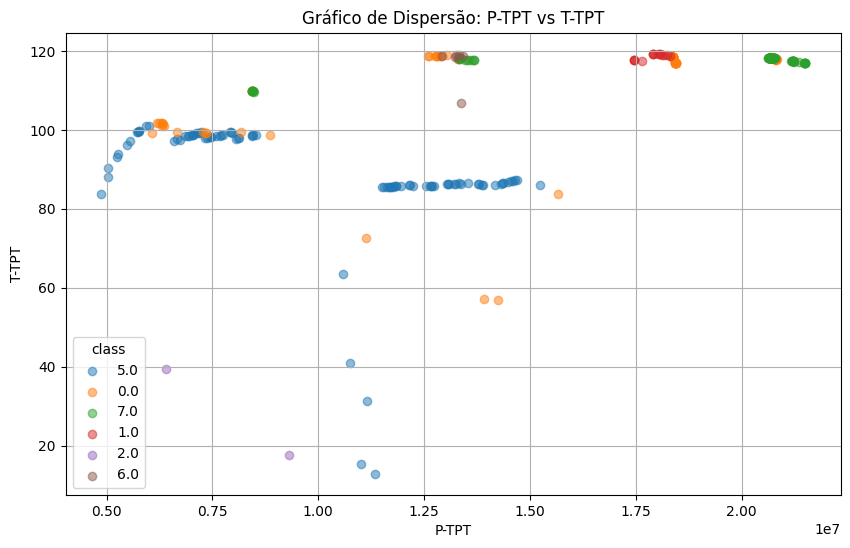

In [531]:
plot_two_variables(df_2, 'P-TPT', 'T-TPT', binary_column="class")

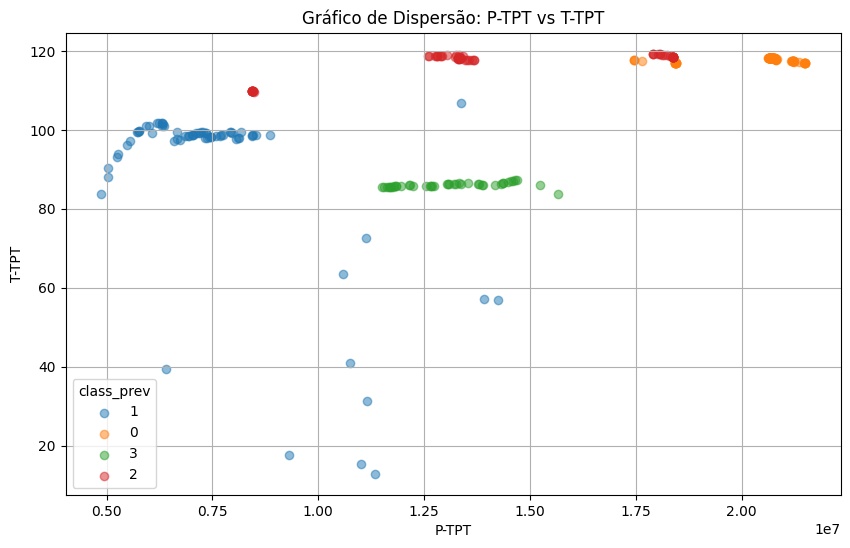

In [532]:
plot_two_variables(df_2, 'P-TPT', 'T-TPT', binary_column="class_prev")

In [533]:
#mapeamento: class_prev: class_real
mapping_class_prev = {
    1: 5,
    3: 5,
    2: 1,
    0:7
}
df_2["class_prev"] = df_2["class_prev"].replace(mapping_class_prev)

C:\Users\marce\AppData\Local\Temp\ipykernel_29188\1873815674.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = df_2["class_prev"].replace(mapping_class_prev)


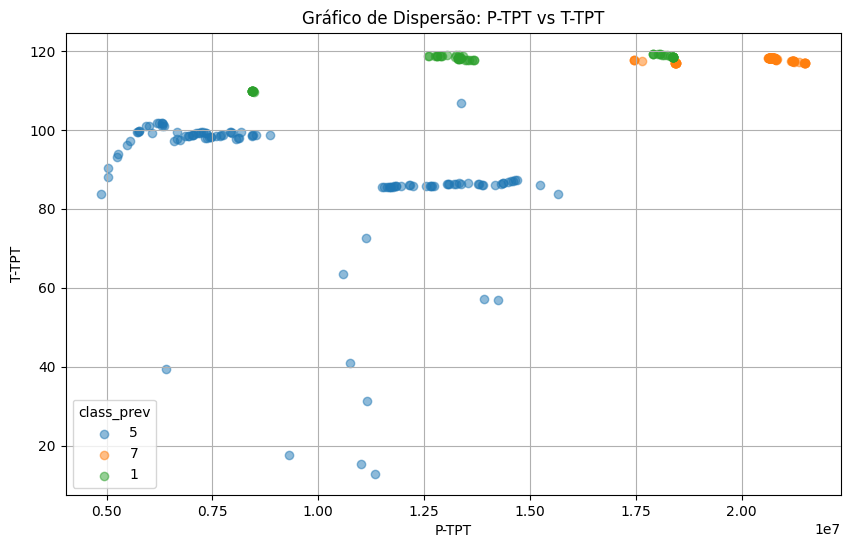

In [534]:
plot_two_variables(df_2, 'P-TPT', 'T-TPT', binary_column="class_prev")

In [535]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Supondo que 'y_true' seja a lista/array com os rótulos verdadeiros e 'y_pred' os rótulos previstos pelo seu modelo
accuracy = accuracy_score(df_2["class"], df_2['class_prev'])
print("Acurácia:", accuracy)

f1_score(df_2["class"], df_2['class_prev'].values, average="macro")

Acurácia: 0.5714285714285714


0.3038229562467443

In [536]:
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, f1_score

# Exemplo de classes reais e previstas (substitua pelos seus dados)
y_true = df_2["class"].values
y_pred = df_2["class_prev"].values

unique_true = np.unique(y_true)
unique_pred = np.unique(y_pred)

# Criar a matriz de confusão
conf_mat = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

# Usar o algoritmo de Hungarian para encontrar o melhor mapeamento
row_ind, col_ind = linear_sum_assignment(-conf_mat)

# Criar um mapeamento de classes previstas para classes reais
mapping = {unique_pred[j]: unique_true[i] for i, j in zip(row_ind, col_ind) if j < len(unique_pred)}

# Reclassificar y_pred de acordo com o mapeamento encontrado
y_pred_mapped = np.array([mapping[p] if p in mapping else -1 for p in y_pred])

# Calcular a acurácia baseada no melhor mapeamento
accuracy = np.mean(y_pred_mapped == y_true)

# Calcular o F1-score baseado no melhor mapeamento
f1 = f1_score(y_true, y_pred_mapped, labels=unique_true, average='weighted')

print(f'Matriz de confusão:\n{conf_mat}')
print(f'Melhor mapeamento (previsto -> real): {mapping}')
print(f'Acurácia: {accuracy:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Acurácia: {accuracy:.4f}')

Matriz de confusão:
[[ 0 45  0 18  0 33]
 [ 0 10  0  0  0  4]
 [ 0  0  0  2  0  0]
 [ 0  0  0 91  0  0]
 [ 0  5  0  1  0  0]
 [ 0 18  0  0  0 67]]
Melhor mapeamento (previsto -> real): {5: 0.0, 7: 2.0, 1: 6.0}
Acurácia: 0.0782
F1-score: 0.0589
Acurácia: 0.0782


In [537]:
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_mapped, labels=unique_true, average=None)

c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [538]:
np.mean(f1)

0.04868742368742369

In [539]:
df_2["class_prev_mapped"] = y_pred_mapped

C:\Users\marce\AppData\Local\Temp\ipykernel_29188\417810924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev_mapped"] = y_pred_mapped


In [540]:
df_aux = df_2.copy()

In [541]:
#df_2.loc[(df_2["class_prev"] == 2) & (df_2["P-TPT"] > 2*10**7), "class_prev"] = 7

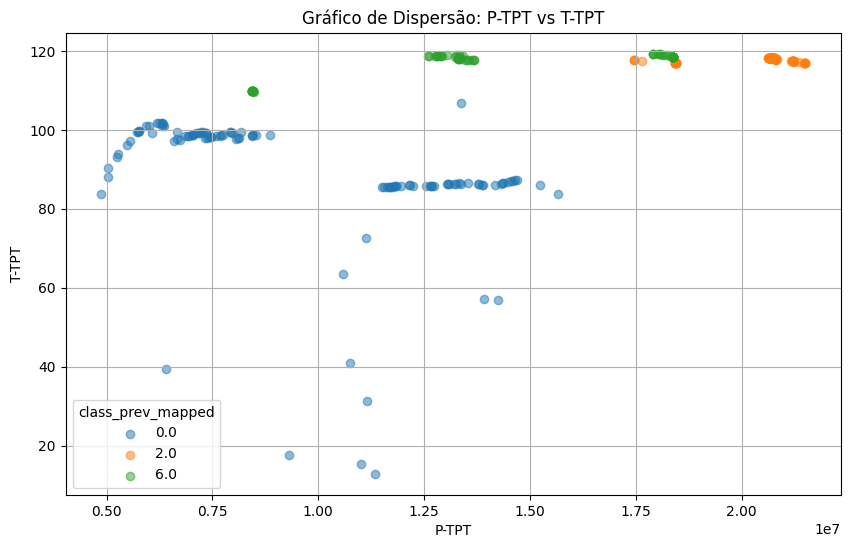

In [542]:
plot_two_variables(df_2, 'P-TPT', 'T-TPT', binary_column="class_prev_mapped")

In [543]:
df_2

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,class_prev,LABEL,class_prev_mapped
timestamp,,,,,,,,
2014-03-18 08:48:25,7583908.0,98.40878,3261349.0,43.81690,5.0,5,R1,0.0
2014-03-19 12:43:55,6337455.0,101.37720,2604916.0,50.60535,0.0,5,R2,0.0
2014-01-24 12:45:17,18437220.0,116.87180,9401221.0,74.79038,0.0,7,R3,2.0
2014-03-14 22:53:27,14355880.0,86.46021,7123661.0,32.15251,5.0,5,R4,0.0
2018-06-18 20:03:04,20647810.0,118.22820,10566870.0,70.51610,7.0,7,R5,2.0
...,...,...,...,...,...,...,...,...
2017-08-01 14:40:00,18234740.0,118.90300,2512656.0,79.66547,1.0,1,R290,6.0
2014-03-15 03:57:32,13765210.0,86.31015,6423888.0,31.33380,5.0,5,R291,0.0
2017-08-01 15:52:46,18174060.0,118.98110,2507937.0,80.05676,1.0,1,R292,6.0


In [544]:
silhouette_score(df_2.drop(columns=["class", "LABEL", "class_prev"]).values, df_2["class_prev"].values)

0.4316227355141108

In [545]:
grouped = df_2.drop(columns=["LABEL", "class_prev"]).groupby('class')

# Calcular as métricas
metrics = grouped.agg(['mean', 'min', 'max', 'std'])

In [546]:
metrics

P-TPT                                             T-TPT  \
               mean         min         max           std        mean   
class                                                                   
0.0    1.500041e+07   6064671.0  21229840.0  4.928366e+06  112.816320   
1.0    1.790926e+07  17455880.0  18313560.0  2.961931e+05  118.674143   
2.0    7.859308e+06   6403813.0   9314802.0  2.058380e+06   28.595775   
5.0    9.910387e+06   4864716.0  15246890.0  3.180078e+06   88.908577   
6.0    1.324429e+07  12921340.0  13406110.0  1.729864e+05  116.796850   
7.0    1.890018e+07   8432354.0  21505640.0  4.019317e+06  117.252802   

                                           P-MON-CKP                         \
             min        max        std          mean        min         max   
class                                                                         
0.0     56.87600  119.08500  11.642907  5.622483e+06   860071.8  12180270.0   
1.0    117.38760  119.30190   0.735635  3.991665e+06  1939581.0   8174609.0   
2.0     17.65200   39.53955  15.476835  3.548119e+06  3167188.0   3929050.0   
5.0     12.90495  101.05020  15.516055  4.157510e+06   840114.9   7661357.0   
6.0    106.84010  118.90300   4.879127  3.757855e+06  2627086.0   5800746.0   
7.0    109.71440  118.23900   2.289958  9.674479e+06  1432335.0  12802170.0   

                     T-JUS-CKP                                 \
                std       mean       min       max        std   
class                                                           
0.0    3.383156e+06  69.590077  18.41833  84.25799  12.800905   
1.0    2.641681e+06  79.760714  77.63908  81.07079   0.939542   
2.0    5.387178e+05  36.142635  30.47859  41.80668   8.010169   
5.0    1.914500e+06  37.731756  26.93791  51.13737   7.847206   
6.0    1.129872e+06  81.270795  73.25974  83.06915   3.943009   
7.0    3.209112e+06  69.435471  61.54692  74.45444   3.362830   

      class_prev_mapped                      
                   mean  min  max       std  
class                                        
0.0            3.500000  0.0  6.0  2.462348  
1.0            4.857143  2.0  6.0  1.875229  
2.0            0.000000  0.0  0.0  0.000000  
5.0            0.000000  0.0  0.0  0.000000  
6.0            5.000000  0.0  6.0  2.449490  
7.0            2.847059  2.0  6.0  1.643935

In [547]:
grouped = df_2.drop(columns=["LABEL", "class"]).groupby('class_prev')

# Calcular as métricas
metrics = grouped.agg(['mean', 'min', 'max', 'std'])

In [548]:
metrics

P-TPT                                             T-TPT  \
                    mean         min         max           std        mean   
class_prev                                                                   
1           1.391401e+07   8429837.0  18373560.0  3.308289e+06  117.010756   
5           9.657734e+06   4864716.0  15669500.0  3.202582e+06   88.662987   
7           2.045534e+07  17455880.0  21505640.0  1.007588e+06  117.787044   

                                               P-MON-CKP             \
                  min       max        std          mean        min   
class_prev                                                            
1           109.71440  119.3019   3.268487  3.407910e+06  1379490.0   
5            12.90495  106.8401  17.416784  4.017331e+06   840114.9   
7           116.87180  118.2390   0.493856  1.067491e+07  7950811.0   

                                      T-JUS-CKP                                \
                   max           std       mean       min       max       std   
class_prev                                                                      
1            5688420.0  1.595374e+06  77.089851  71.03691  84.25799  3.886353   
5            7890380.0  1.881123e+06  39.260257  18.41833  73.25974  9.033740   
7           12802170.0  1.090911e+06  70.025529  61.54692  79.23173  3.716045   

           class_prev_mapped                 
                        mean  min  max  std  
class_prev                                   
1                        6.0  6.0  6.0  0.0  
5                        0.0  0.0  0.0  0.0  
7                        2.0  2.0  2.0  0.0

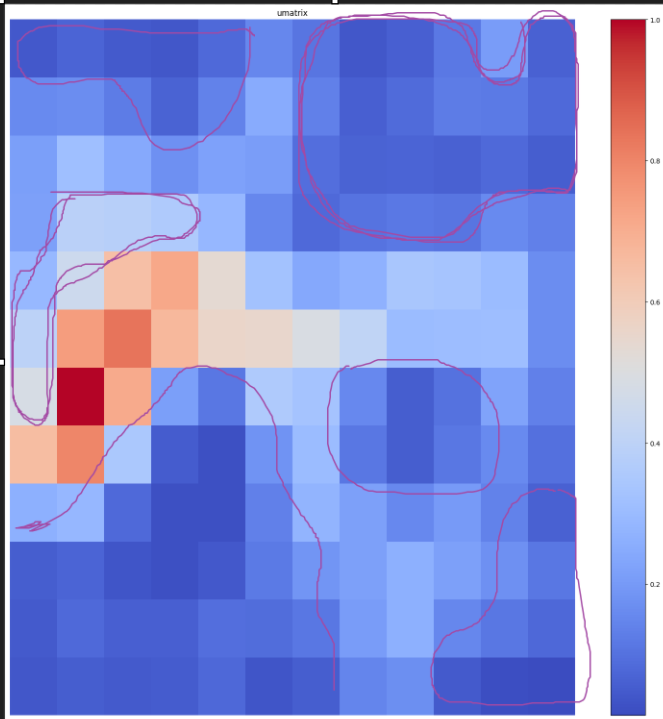

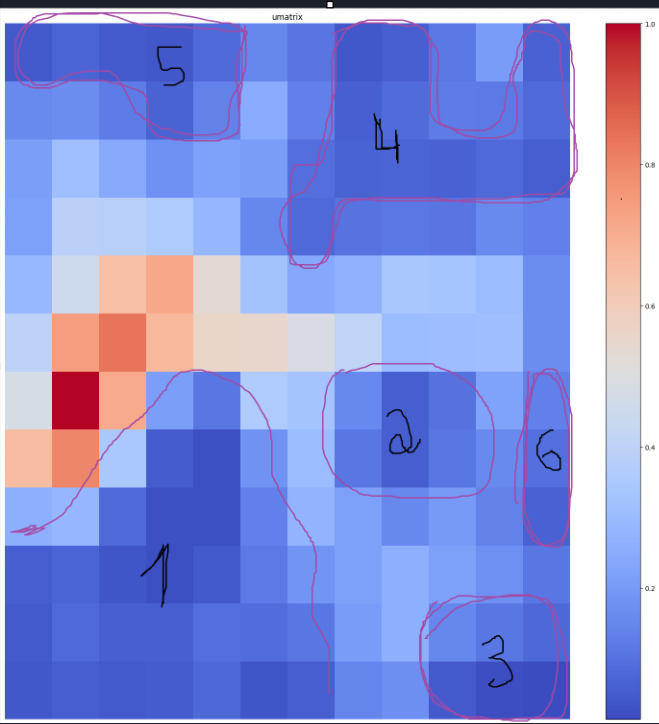

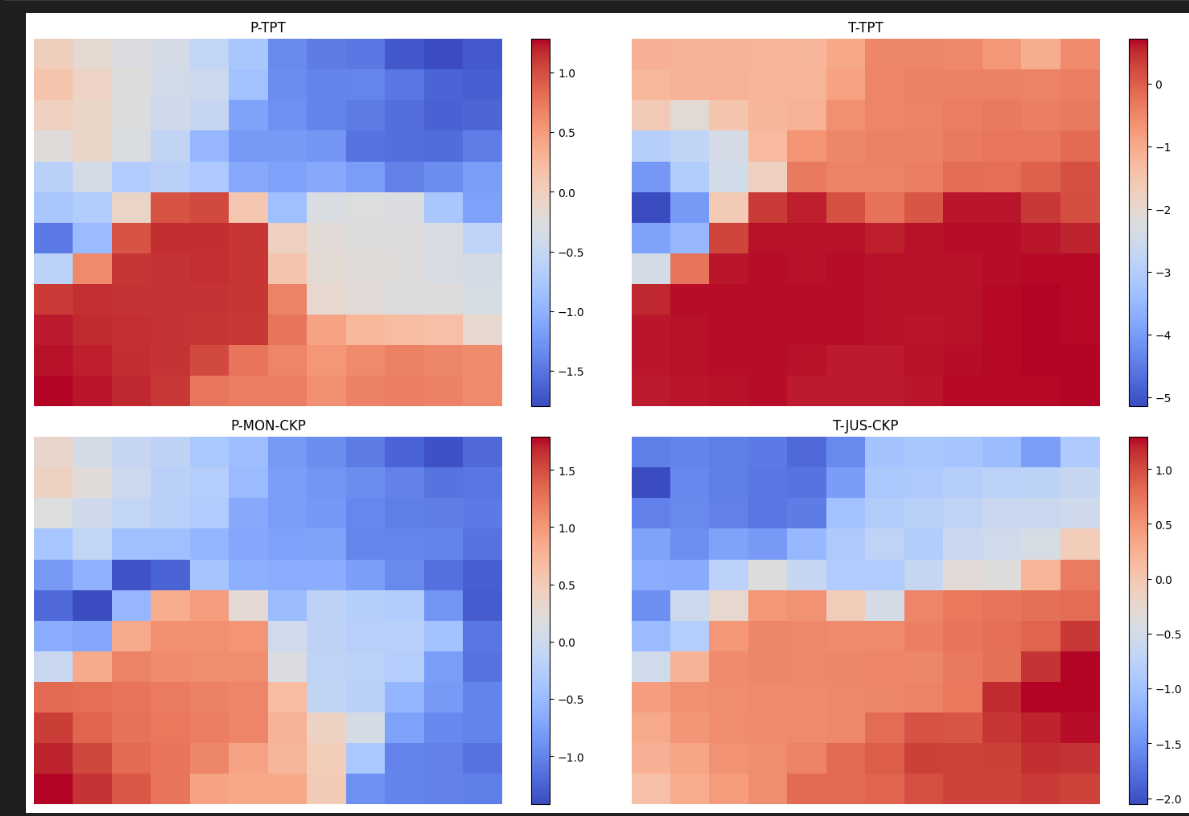

# Conclusões

cluster 1: 
- P-TPT: Muito Alta
- T-TPT: Muito Alta
- P-MON-CKP: Alta
- T-JUS-CKP: Alta

cluster 2:
- P-TPT: Média
- T-TPT: Muito alta
- P-MON-CKP: Média
- T-JUS-CKP: Alta


Cluster 3:
- P-TPT: Alta
- T-TPT: Muito alta
- P-MON-CKP: Baixa
- T-JUS-CKP: Alta


Cluster 4:
- P-TPT: Muito baixa
- T-TPT: Alta
- P-MON-CKP: Muito baixa
- T-JUS-CKP: Média

Cluster 5:
- P-TPT: Média
- T-TPT: Alta
- P-MON-CKP: Média
- T-JUS-CKP: Muito baixa

Cluster 6:
- P-TPT: Média
- T-TPT: Muito Alta
- P-MON-CKP: Muito baixa
- T-JUS-CKP: Muito alta

Cluster 6.1:
- P-TPT: Baixa
- T-TPT: Muito Baixa
- P-MON-CKP: Muito baixa
- T-JUS-CKP: Baixa

Apresentar mapa das variáveis. umatrix e os dois mapas de neuronios vencedores (com a minha rotulagem e com a rotulagem original)

In [549]:
category_color = {0: 'darkgreen',
                  1: 'limegreen',
                  2: 'darkorange',
                  3: 'crimson',
                  4: 'dodgerblue',
                  5: 'purple',
                  6: 'royalblue'}

In [550]:
df_2["class_prev"].unique()

array([5, 7, 1])

In [551]:
colors_dict = {c: category_color[c] for c in df_2["class_prev"]}

KeyError: 7

# Mapa com a minha rotulagem

In [ ]:
som.plot_winning(country_map,alias_label=shorten_country,colorize=colors_dict,label_color=category_color)

KeyError: 'R1'

<Figure size 1400x1400 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Supondo que 'y_true' seja a lista/array com os rótulos verdadeiros e 'y_pred' os rótulos previstos pelo seu modelo
accuracy = accuracy_score(df_2["class"], df_2['class_prev'])
print("Acurácia:", accuracy)

Acurácia: 0.48639455782312924


In [ ]:
f1_score(df_2["class"], df_2['class_prev'].values, average="macro")

0.43938194795876767

In [ ]:
precision = precision_score(df_2["class"], df_2['class_prev'].values, average=None)
recall = recall_score(df_2["class"], df_2['class_prev'].values, average=None)
f1 = f1_score(df_2["class"], df_2['class_prev'].values, average=None)

for i in range(len(precision)):
    print(f'Classe {np.unique(df_2["class"])[i]}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1-score: {f1[i]}\n')

Classe 0.0:
Precision: 0.22413793103448276
Recall: 0.13541666666666666
F1-score: 0.16883116883116883

Classe 1.0:
Precision: 0.358974358974359
Recall: 1.0
F1-score: 0.5283018867924528

Classe 2.0:
Precision: 0.2222222222222222
Recall: 1.0
F1-score: 0.3636363636363636

Classe 5.0:
Precision: 0.9318181818181818
Recall: 0.45054945054945056
F1-score: 0.6074074074074074

Classe 6.0:
Precision: 0.10714285714285714
Recall: 1.0
F1-score: 0.19354838709677416

Classe 7.0:
Precision: 0.7613636363636364
Recall: 0.788235294117647
F1-score: 0.7745664739884393



# Salvando modelo SOM para não treinar novamente

In [ ]:
import dill

In [ ]:
file_path = 'modelo_som_maior.dill'

# Salvando o modelo SOM usando dill
with open(file_path, 'wb') as f:
    dill.dump(som, f)

In [ ]:

# Carregando o modelo SOM salvo
with open(file_path, 'rb') as f:
    som_test = dill.load(f)

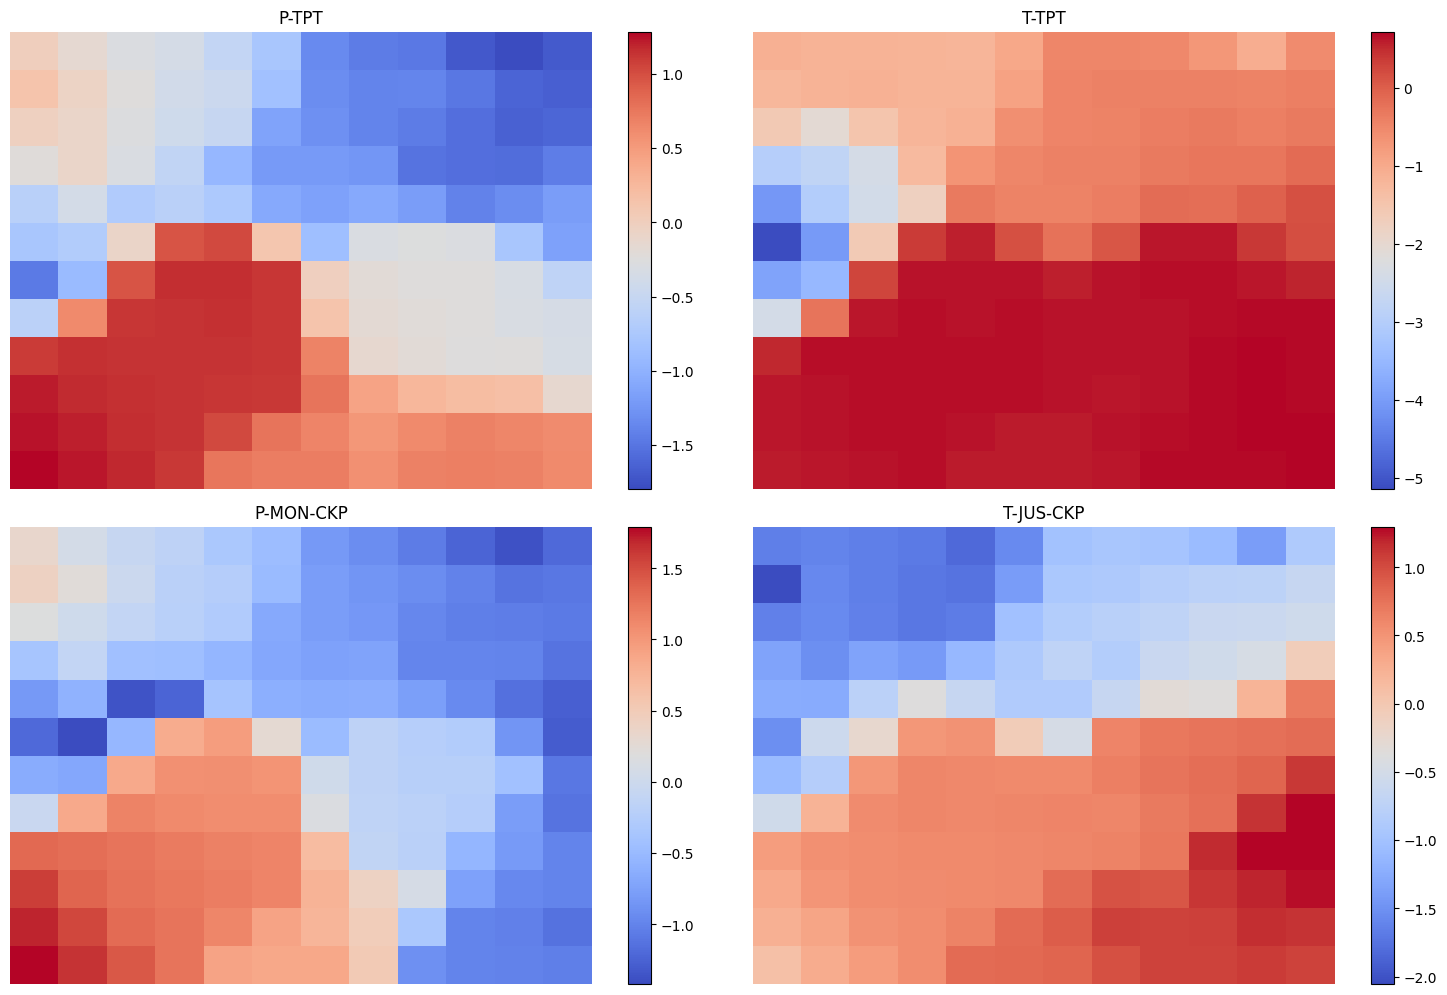

In [ ]:
som_test.plot_map(nrows=3,ncols=2,feature_names=model_input)